# Deep Learning and Neural Networks
### Image classification using neural networks

The dataset has the images stored as vector form. Each image is a 16X16 image and represented in a vector of 256 length 
The dataset is split into trian and test set. 
Each vector represents a number and can be seen in output csv files

Packages used

In [1]:
import numpy as np
from os import getcwd, chdir, path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, colors
from sklearn.metrics import pairwise_distances, confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

figsize = (14, 8)

File definitions

In [2]:
mypath = path.join(getcwd(), 'data')
fileDict = {'test': 'test_in.csv', 'test_label':'test_out.csv', 'train':'train_in.csv', 'train_label':'train_out.csv'}

Class for performing the image classification

In [3]:
class imageDist:
    '''This class implements methods for calculation of center radius and distances between clouds'''
    def __init__(self, train_values, train_label):
        self.train_values = train_values
        self.train_label = train_label
        self.digits = range(len(np.unique(train_label)))
        self.dim = len(self.train_values.iloc[0,:])
        
    def calcCentre(self):
        '''Calculates the centre for each coordinate for each digit'''
        self.centers = np.zeros((len(self.digits), self.dim))
        for d in self.digits:
            for x in range(self.dim):
                ## Calculating mean of each digits d in train set
                self.centers[d, x] = np.mean(self.train_values.iloc[self.train_label == d, x])
        return self.centers
            
    def calcRadius(self):
        '''Calculates the radius'''
        self.radius = np.zeros(len(self.digits))
        for d in self.digits:
            ## Finds the maximum distance between center and input dataset for each digit d
            self.radius[d] = pd.DataFrame(pairwise_distances(self.train_values.iloc[self.train_label == d,:], 
                                                             cloud_center)).max()[d]
        return self.radius
    
    def distBtwnClouds(self):
        '''heatmap of the cloud'''
        ## Calculating cloud distances using euclidean distance
        cloudDists = pairwise_distances(cloud_center, cloud_center) * -1
        heat = sns.heatmap(cloudDists, linewidth=0.05, cmap="YlGnBu", 
                    vmin = np.floor(np.min(cloudDists)),vmax=np.ceil(np.max(cloudDists))).invert_yaxis()
        heat=plt.gca()
        heat.set_ylim(-0.5, (np.max(self.digits)+1))
        plt.title("Distance between clouds")
        plt.show()

In [4]:
def fileRead(mypath, file):
    return pd.read_csv(path.join(mypath, file),  header=None)

In [38]:
train_values = fileRead(mypath, fileDict['train'])
train_label = np.array(fileRead(mypath, fileDict['train_label'])[0])
test_values = fileRead(mypath, fileDict['test'])
test_label = np.array(fileRead(mypath, fileDict['test_label'])[0])

#### Task 1: Analyze distance between images

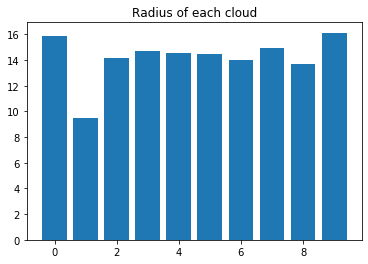

Wall time: 777 ms


In [6]:
%%time
ImageClassifier = imageDist(train_values, train_label)
cloud_center = ImageClassifier.calcCentre()
radius = ImageClassifier.calcRadius()
plt.bar(range(len(radius)), radius)
plt.title("Radius of each cloud")
plt.show()

Figure 1: This figure shows radius of all 10 clouds.  Radius of cloud is calculated as the distance from the cen-ter to the most distant point of the cloud.  As we can see in the image some of values are very close to each other.

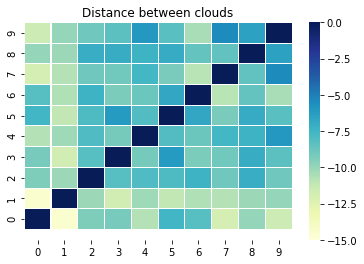

In [7]:
ImageClassifier.distBtwnClouds()

Figure 2: This figure represents the distance between the clouds. It can be seen that digits 1 has quiet large distance with other digits. Thus it can be said that digit 1 has least chances to be misclassified. Some digits have small distances such as 4, 7 and 9, thus they have high probability of getting misclassified.

#### Task 2: Distance classifier

##### Exploratory Data Analysis

In [8]:
def EDA(ax, values, label, title):
    '''Edit the code a bit'''
    centre_circle = plt.Circle((0,0),0.8,fc='white')
    digits = range(len(np.unique(label)))
    data = list(map(lambda x: len(values.iloc[label==x]), np.unique(label)))
    explode = np.full(len(digits), 0.1)
    ax.pie(list(map(lambda x: x*100/sum(data), data)), colors=cm.tab20(digits), labels=digits, 
            autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
    ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
    ax.set_title(title, pad=20)
    plt.gcf().gca().add_artist(centre_circle)
    return ax

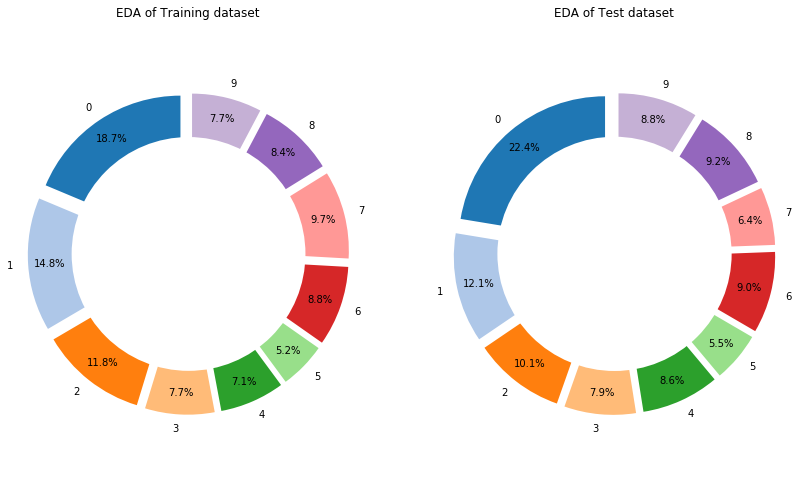

In [9]:
fig = plt.figure(figsize=figsize)
grid = plt.GridSpec(1, 2, hspace=0.2, wspace=0.2)
EDA(fig.add_subplot(grid[0]), train_values, train_label, 'EDA of Training dataset')
EDA(fig.add_subplot(grid[1]), test_values, test_label, 'EDA of Test dataset')
plt.show()

Figure 3: Shows the spread of the training and test data sets. Percetange of each label in the data set.

In [61]:
def classifier(values, label, cloud, DT='ED', digits=range(10)):
    ''''Distance based classifier'''
    if DT =='ED':
        distance = pairwise_distances(values, cloud, metric='euclidean')
    elif DT=='CS':
        distance = pairwise_distances(values, cloud, metric='cosine')
    elif DT=='MH':
        distance = pairwise_distances(values, cloud, metric='manhattan')
    
    
    ## Taking the minimum distances
    preds = pd.DataFrame(distance).idxmin(axis=1)
    
    ## Caclulating the accuracy
    acc = 0
    for a, b in zip(preds, label):
        if a == b: acc+=1
    
    print("Accuracy of the classifiers: "+str(acc/len(label)*100))
    print(classification_report(label, preds))
    return confusion_matrix(y_true=label, y_pred=preds, labels=list(digits))

In [62]:
## First with the train set
ED_confusion_matrix= classifier(train_values, train_label, cloud_center)
pd.DataFrame(ED_confusion_matrix)

Accuracy of the classifiers: 86.35032220269478
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       319
           1       0.92      1.00      0.96       252
           2       0.94      0.83      0.88       202
           3       0.84      0.92      0.88       131
           4       0.75      0.78      0.76       122
           5       0.84      0.76      0.80        88
           6       0.74      0.85      0.79       151
           7       0.92      0.84      0.88       166
           8       0.86      0.84      0.85       144
           9       0.74      0.85      0.79       132

    accuracy                           0.86      1707
   macro avg       0.85      0.85      0.85      1707
weighted avg       0.87      0.86      0.86      1707



,0,1,2,3,4,5,6,7,8,9
0,271,0,0,0,2,4,36,0,6,0
1,0,252,0,0,0,0,0,0,0,0
2,3,0,167,9,9,1,3,4,6,0
3,0,0,2,120,1,3,0,1,3,1
4,0,8,1,0,95,0,3,0,0,15
5,3,0,2,3,4,67,3,1,2,3
6,10,4,5,0,2,0,129,0,1,0
7,0,4,0,0,2,2,0,140,1,17
8,1,2,1,10,2,3,1,0,121,3
9,0,3,0,1,10,0,0,6,0,112


Table 1: Classification report and Confusion matrix for trainig data set

In [63]:
## Second run on test set
test_confusion_matrix= classifier(test_values, test_label, cloud_center)
pd.DataFrame(test_confusion_matrix)

Accuracy of the classifiers: 80.4
              precision    recall  f1-score   support

           0       0.90      0.79      0.85       224
           1       0.91      0.99      0.95       121
           2       0.85      0.68      0.76       101
           3       0.75      0.77      0.76        79
           4       0.67      0.80      0.73        86
           5       0.72      0.69      0.70        55
           6       0.75      0.87      0.80        90
           7       0.85      0.78      0.81        64
           8       0.74      0.79      0.76        92
           9       0.75      0.77      0.76        88

    accuracy                           0.80      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.81      0.80      0.80      1000



,0,1,2,3,4,5,6,7,8,9
0,178,0,3,2,4,2,23,1,10,1
1,0,120,0,0,0,0,1,0,0,0
2,2,0,69,6,8,1,0,2,13,0
3,3,0,3,61,1,8,0,0,1,2
4,1,3,3,0,69,0,1,1,0,8
5,3,0,0,6,3,38,1,0,0,4
6,7,0,2,0,2,1,78,0,0,0
7,0,2,1,0,5,0,0,50,0,6
8,3,2,0,6,3,3,0,0,73,2
9,0,5,0,0,8,0,0,5,2,68


Table 2: Classification report and Confusion matrix for test data set

In [64]:
CS_confusion_matrix = classifier(train_values, train_label, cloud_center, 'CS')

CS_confusion_matrix_test = classifier(test_values, test_label, cloud_center, 'CS')

MH_confusion_matrix = classifier(train_values, train_label, cloud_center, 'MH')

MH_confusion_matrix_test = classifier(test_values, test_label, cloud_center, 'MH')

Accuracy of the classifiers: 86.05741066198009
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       319
           1       0.88      1.00      0.94       252
           2       0.95      0.80      0.87       202
           3       0.83      0.92      0.88       131
           4       0.75      0.77      0.76       122
           5       0.89      0.77      0.83        88
           6       0.73      0.86      0.79       151
           7       0.90      0.85      0.87       166
           8       0.89      0.83      0.86       144
           9       0.74      0.85      0.79       132

    accuracy                           0.86      1707
   macro avg       0.85      0.85      0.85      1707
weighted avg       0.87      0.86      0.86      1707

Accuracy of the classifiers: 79.9
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       224
           1       0.84      1.00      0.91       1

Table 3: Classification reports for trainig and test data set using cosine and manhattan distances respectively

#### Task 3 Multi-class perceptron

In [100]:
## Appending the biases in the input data
train_values[256] = np.full(len(train_label), 1)
test_values[256] = np.full(len(test_label), 1)

In [15]:
def plot_graph(errors):
    ## Plots the error vs epoch graph
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(range(len(errors)), errors, c = 'red')
    plt.ylabel('Errors')
    plt.xlabel('Number of Epochs')
    plt.title('Errors vs Epochs')
    plt.show()
    
def accuracy(preds, target):
    a = 0
    for p, t in zip(preds, target):
        if p == t:
            a+=1
    print("Accuracy of the perceptron is %.3f" %((a/len(target)*100)))

In [16]:
class Perceptron:
    def __init__(self, nodes=256, epochs=100):
        self.epochs = epochs
        self.weights = np.zeros((10, nodes + 1)) 
    
    def predict(self, inputs):
        ## Returns the node with maximum activation value after dot product
        return np.argmax(np.dot(inputs, self.weights.T), axis=1)
                         
    def fit(self, in_values, in_labels):
        errors = np.zeros(self.epochs)
        for epoch in range(self.epochs):
            preds = self.predict(in_values)
            for ind, target in enumerate(in_labels):
                ## If the predicted values do not match with the target update the weights
                if preds[ind] != target:
                    errors[epoch] += 1                
                    update = in_values[ind, :-1]
                    self.weights[target,:-1] += update
                    self.weights[preds[ind],:-1] -= update
                    self.weights[:,-1] = 1
        plot_graph(errors)
        return(self.weights)

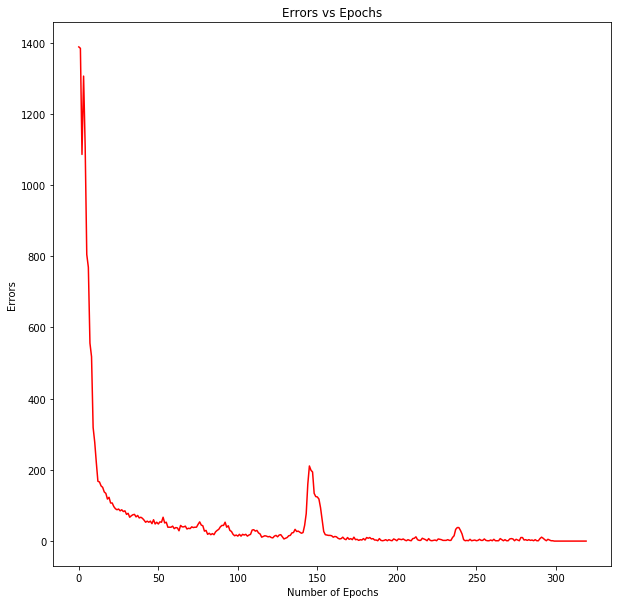

For the test dataset:
Accuracy of the perceptron is 86.700
Wall time: 690 ms


In [17]:
%%time
perceptron = Perceptron(nodes=256, epochs=320)
weights = perceptron.fit(train_values.to_numpy(), train_label)
preds = perceptron.predict(test_values.to_numpy())
print("For the test dataset:")
accuracy(preds, test_label)

Figure 4: Error vs Epochs for training of multi-class perceptron. It can be seen with increase in epochs the error rate is going down meaning perceptron is learning.

In [97]:
class Perceptron_2:
    def __init__(self, nodes=256, epochs=100):
        self.epochs = epochs
        self.weights = np.zeros((10, nodes + 1)) 
    
    def predict(self, inputs):
        return np.argmax(np.dot(inputs, self.weights.T), axis=1)
                         
    def fit(self, in_values, in_labels):
        errors = np.zeros(self.epochs)
        for epoch in range(self.epochs):
            preds = self.predict(in_values)
            for ind, target in enumerate(in_labels):
                if preds[ind] != target:
                    errors[epoch] += 1  
                    ## 0.1 learning rate
                    ## formulae: input value * learning rate * error 
                    update = in_values[ind] * 1 * (target - preds[ind])
                    self.weights[target] += update
                    self.weights[preds[ind]] -= update
        plot_graph(errors)
        return(self.weights)


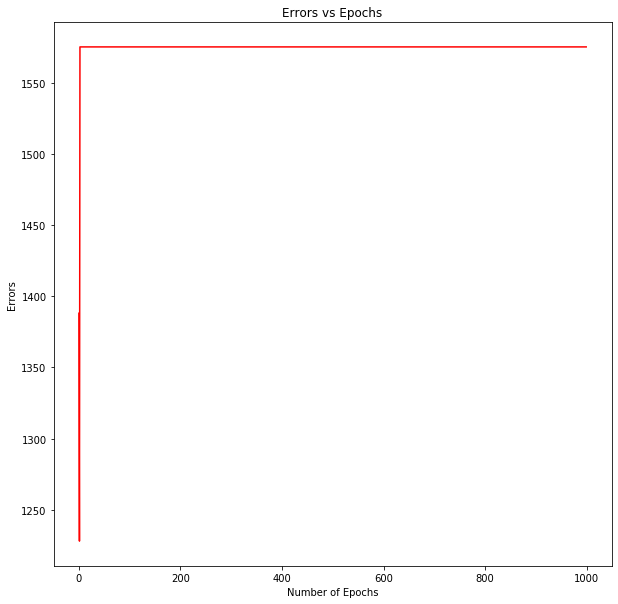

For the test dataset:
Accuracy of the perceptron is 8.800
Wall time: 27.2 s


In [99]:
%%time
perceptron_2 = Perceptron_2(nodes=256, epochs=1000)
weights = perceptron_2.fit(train_values.to_numpy(), train_label)
preds = perceptron_2.predict(test_values.to_numpy())
print("For the test dataset:")
accuracy(preds, test_label)

Figure 5: Error vs Epochs for training of multi-class perceptron. It can be seen with increase in epochs the error rate is not going down meaning the perceptron is not able to learn.

#### Task 4: Linear Separability
#### Principal Component Analysis

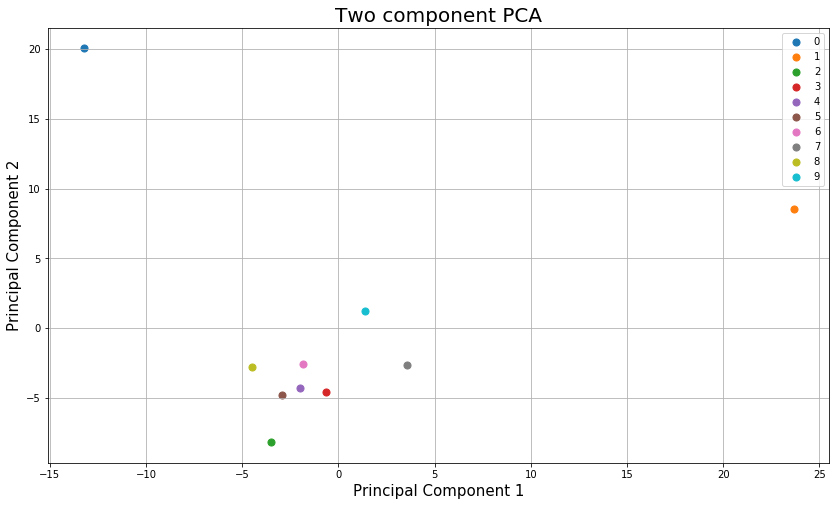

In [33]:
newWeights = StandardScaler().fit_transform(weights)
pca = PCA(n_components=2)
finalDf = pd.concat([pd.DataFrame(pca.fit_transform(newWeights)), 
                     pd.DataFrame(list(range(10)), columns=['label'])], 
                    axis = 1)
plt.figure(figsize = figsize)
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('Two component PCA', fontsize = 20)
targets = list(range(10))
for target in targets:
    plt.scatter(finalDf.loc[finalDf['label'] == target, 0], finalDf.loc[finalDf['label'] == target, 1], s = 50)
plt.legend(targets)
plt.grid()
plt.show()

Figure 6: PCA of the training with two axes. It shows that 0 and 1 are the most separable, and 4 and 5 can be hard to separate

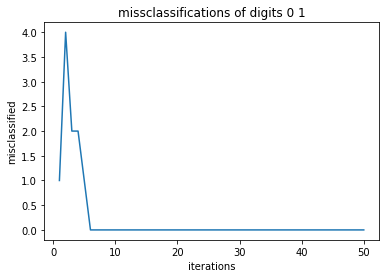

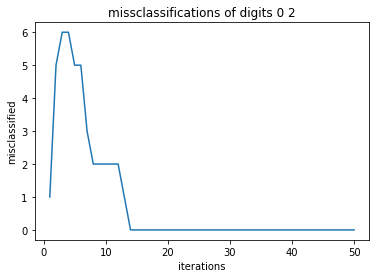

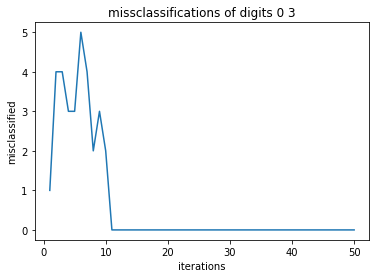

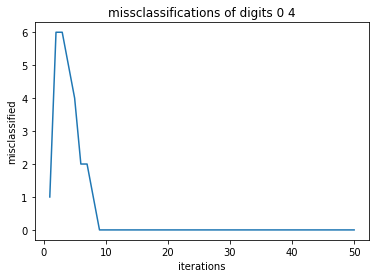

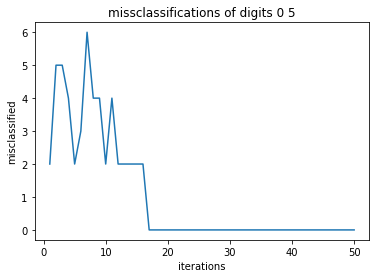

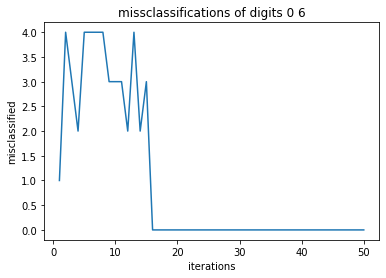

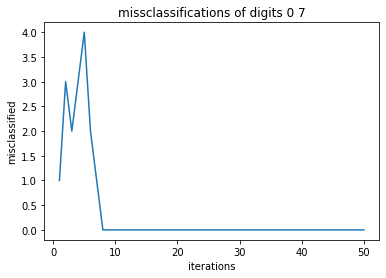

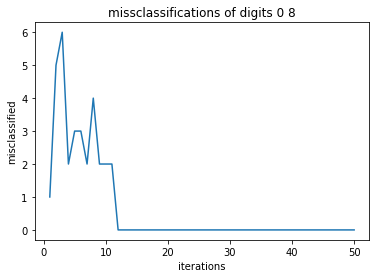

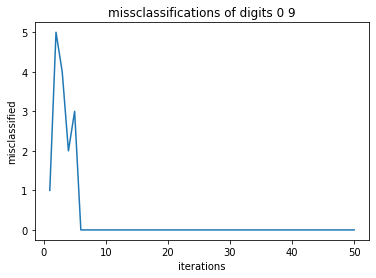

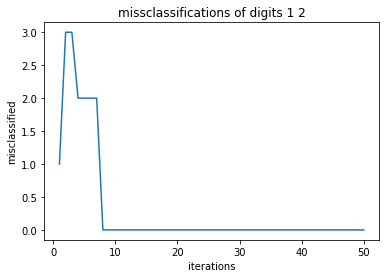

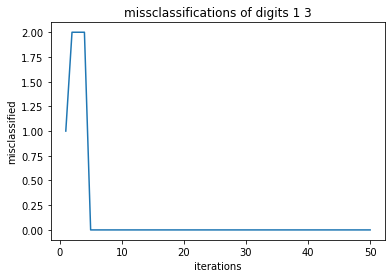

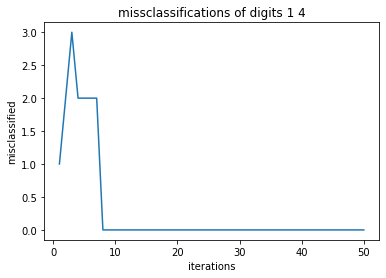

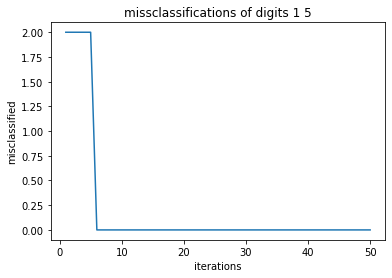

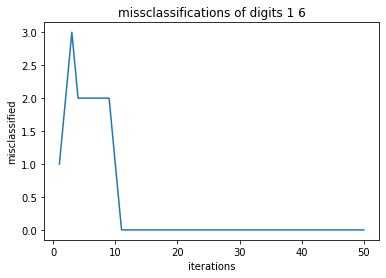

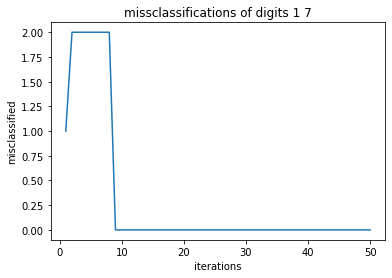

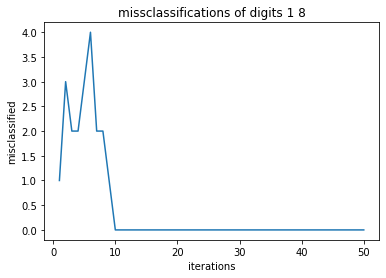

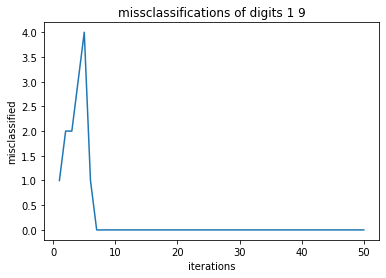

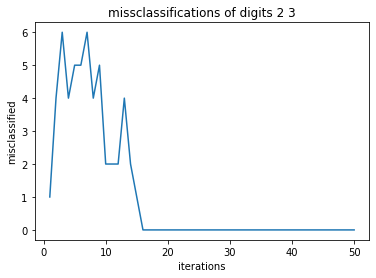

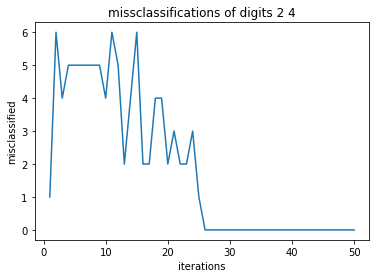

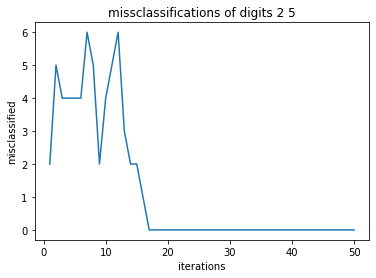

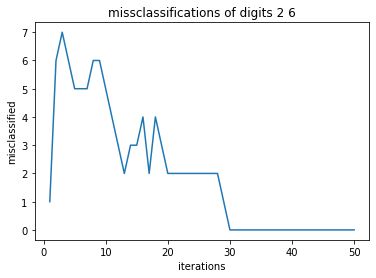

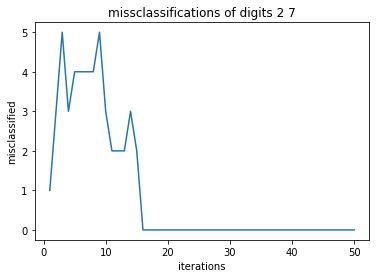

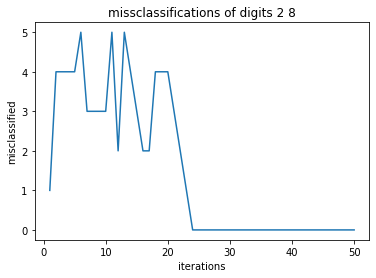

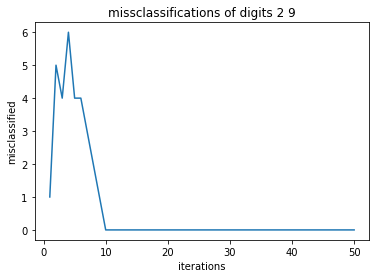

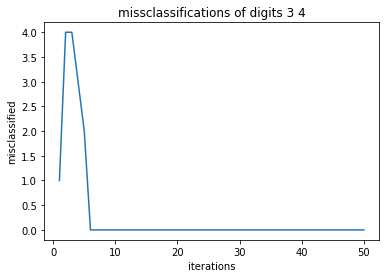

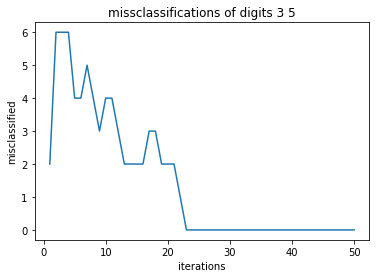

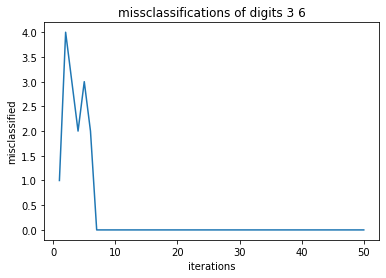

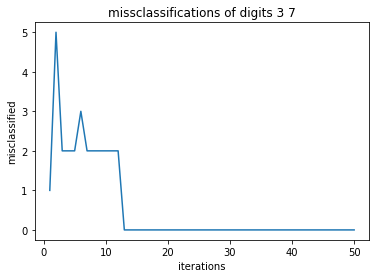

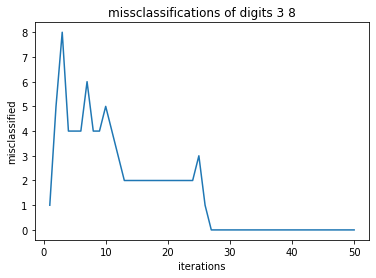

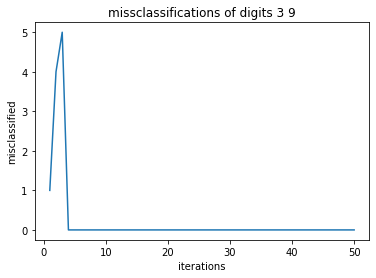

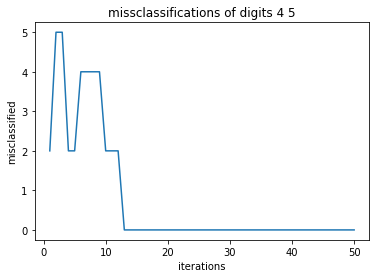

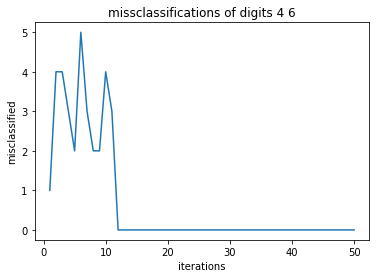

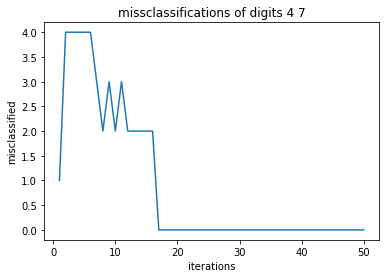

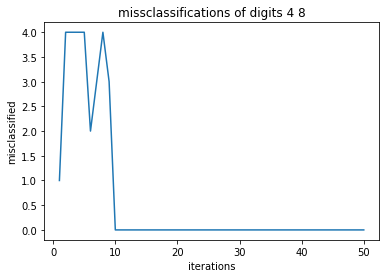

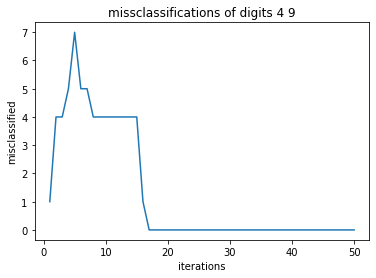

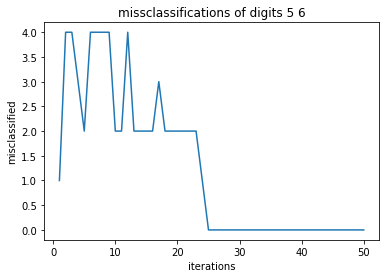

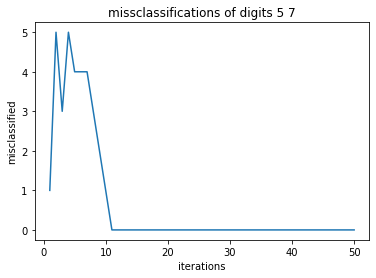

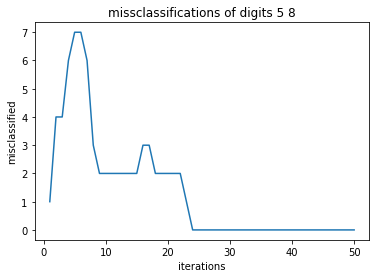

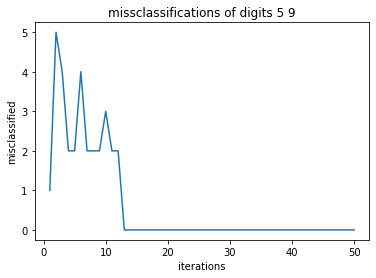

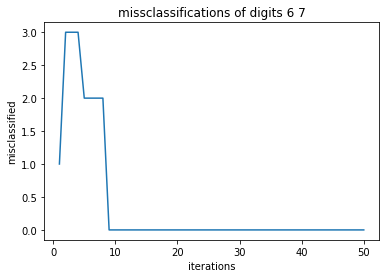

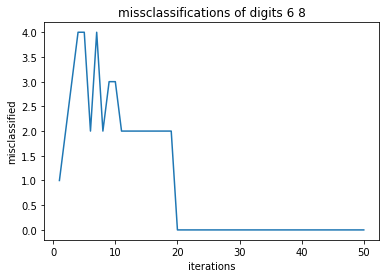

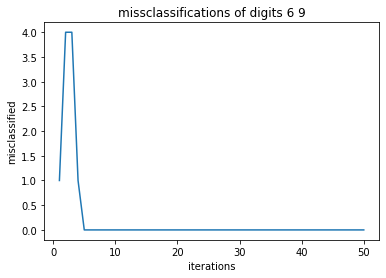

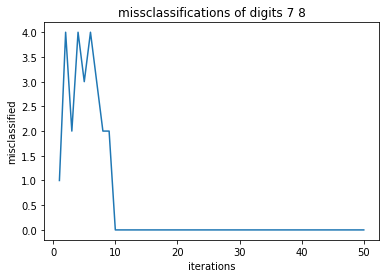

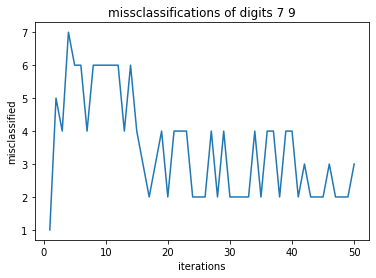

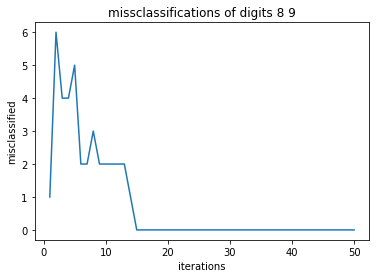

In [103]:
test_in = pd.read_csv("data/test_in.csv" , names =  np.arange(start=0, stop=256, step=1) )
test_out = pd.read_csv("data/test_out.csv", names =  ["256"])
train_in = pd.read_csv("data/train_in.csv", names =  np.arange(start=0, stop=256, step=1))
train_out = pd.read_csv("data/train_out.csv", names =  ["256"])
data = pd.concat([train_in, train_out], axis=1)
def perceptron(data, num_iter ):
    
    features = data[:, :-1]
    labels = data[:, -1]
    
    # set weights to zero
    w = np.zeros(shape=(1, features.shape[1]+1))
    
    misclassified_ = [] 
  
    for epoch in range(num_iter):
        misclassified = 0
        for x, label in zip(features, labels):
            x = np.insert(x,0,1)
            y = np.dot(w, x.transpose())
            target = 1.0 if (y > 0) else 0.0
            
            delta = (label.item(0,0) - target)
            
            if(delta): # misclassified
                misclassified += 1
                w += (delta * x)
        
        misclassified_.append(misclassified)
    return (w, misclassified_)

for i in range(10):
    for j in range(i+1 ,10):
      data =  pd.concat( [data[data.iloc[:,256] == i ] , data[data.iloc[:,256]  == j] ])
      data['256'] = data['256'].replace( i , 0)
      data['256'] = data['256'].replace( j , 1)
      
      data = data.to_numpy()
      data = np.asmatrix(data, dtype = 'float64')
      
      num_iter = 50
      w, misclassified_ = perceptron(data, num_iter)

      epochs = np.arange(1, num_iter+1)
      plt.plot(epochs, misclassified_)
      plt.xlabel('iterations')
      plt.ylabel('misclassified' )
      plt.title( "missclassifications of digits"+ ' ' + str(i ) +' '+ str( j ) )
      plt.show()
      data = pd.concat([train_in, train_out], axis=1)

#### Task 5: XOR with stochastic gradient descent

In [20]:
def sigmoid(x):
    s = 1/(1 + np.exp(-x))
    return s

In [21]:
def sigmoid_grad(x):
    s=sigmoid(x)
    return s*(1-s)

In [22]:
def tanh(x):
    return np.tanh(x)

In [23]:
def tanh_der(x):
    return 1-np.tanh(x)**2

In [24]:
class XOR_GD:
    def __init__(self, hidden_weights, hidden_bias, output_weights, output_bias):
        ## Intialzing the wieghts and bias
        self.hidden_weights, self.hidden_bias, self.output_weights, self.output_bias = hidden_weights, hidden_bias, output_weights, output_bias
        
    def xor_net(self, X, actFunc):
        ## Calculating the output of hidden layer by taking the dot product of wieghts and input and adding the bias
        self.hidden_layer = actFunc(X.dot(self.hidden_weights) + self.hidden_bias)
        ## Calculating the output of output layer by taking the dot product of wieghts and output of hidden layer and adding the bias
        self.output_layer = sigmoid(self.hidden_layer.dot(self.output_weights) + self.output_bias)
    
    def mse(self, y_true, deriFunc):
        ## Calculating the error
        error = y_true - self.output_layer
        
        ## Cacluating the error in output layer using gradient descent
        self.output_error = error * sigmoid_grad(self.output_layer)
        
        ## Calculating the error in hidden layer
        self.hidden_error = (self.output_error.dot(self.output_weights.T)) * deriFunc(self.hidden_layer)
        
        return error
    
    def gdmse(self, X, lr):
        ## Updating the weights
        self.output_weights+= self.hidden_layer.T.dot(self.output_error) * lr
        self.output_bias+= np.sum(self.output_error,axis=0,keepdims=True) * lr
        
        self.hidden_weights+= X.T.dot(self.hidden_error) * lr
        self.hidden_bias+= np.sum(self.hidden_error,axis=0,keepdims=True) * lr

    def fit(self, X, y_true, lr, actFunc=sigmoid, deriFunc=sigmoid_grad, epochs=2*10**5):
        errors = np.empty(0)
        misclassified = np.empty(0)
        amount_misclassified = 1
        i = 0
        while amount_misclassified > -1: ## Running it for epochs ## Can use 0 instead of -1 to stop when no misclassification
            self.xor_net(X, actFunc) # for every iteration, forward propagation is carried out
            ## back propogation
            error = self.mse(y_true, deriFunc)
            self.gdmse(X, lr)

            classified = np.piecewise(self.output_layer, [self.output_layer < 0.5, self.output_layer >= 0.5], [0,1])
            amount_misclassified = np.sum(classified!=y_true)
            errors = np.append(errors, np.mean(error**2))
            misclassified = np.append(misclassified , amount_misclassified)   
            i += 1
            if i == epochs:
                break
        return self.output_layer, errors, misclassified

In [25]:
X=np.array([[0,0],[0,1],[1,0],[1,1]])
Y=np.array([[0,1,1,0]]).T
np.random.seed(2)
inputs, hidden_nodes = X.shape[1], 2
lr, hw, hb, ow, ob = 0.01, np.random.uniform(size=(inputs, hidden_nodes)), np.random.uniform(size=(1, hidden_nodes)), np.random.uniform(size=(hidden_nodes, 1)), np.random.uniform(size=(1, 1))

In [28]:
XOR_tan = XOR_GD(hw, hb, ow, ob)
y_pred, errors, misclassified = XOR_tan.fit(X, Y, lr, actFunc=tanh, deriFunc=tanh_der)

Predicted Output:
[[0.00332817]
 [0.99707598]
 [0.99707598]
 [0.00336793]]


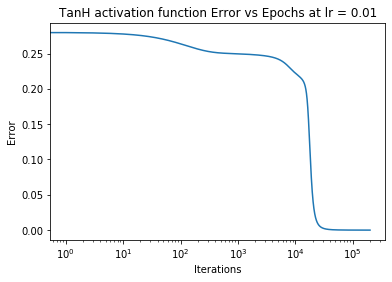

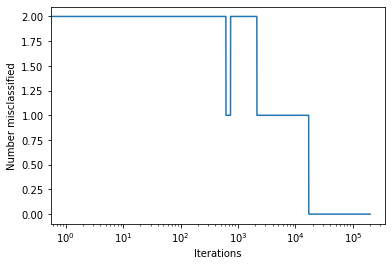

In [29]:
print('Predicted Output:')
print(y_pred) 
plt.semilogx(errors)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title(str('TanH activation function Error vs Epochs at lr = '+str(lr)))
plt.show()
plt.semilogx(misclassified)
plt.xlabel('Iterations')
plt.ylabel('Number misclassified')
plt.show()

Figure 8: Above plot shows decrease in error and number of misclassification by the XOR net with increase in epochs

In [30]:
XOR_sig = XOR_GD(hw, hb, ow, ob)
y_pred, errors, misclassified = XOR_sig.fit(X, Y, lr, actFunc=sigmoid, deriFunc=sigmoid_grad)

Predicted Output:
[[0.01788412]
 [0.97606272]
 [0.97606272]
 [0.02068404]]


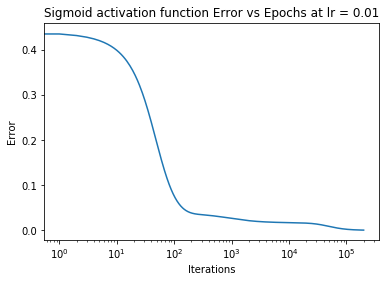

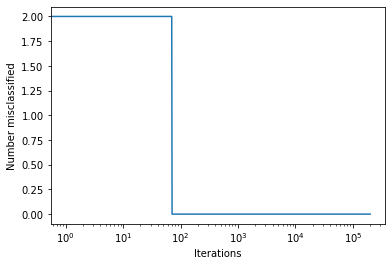

In [31]:
print('Predicted Output:')
print(y_pred) 
plt.semilogx(errors)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title(str('Sigmoid activation function Error vs Epochs at lr = '+str(lr)))
plt.show()
plt.semilogx(misclassified)
plt.xlabel('Iterations')
plt.ylabel('Number misclassified')
plt.show()

Figure 9: Above plot shows decrease in error and number of misclassification by the XOR net with increase in epochs